In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, cohen_kappa_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Connecting google drive with code file
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Changing path to project folder
%cd /content/drive/MyDrive/AutomatedEssayGrading-FYP

Mounted at /content/drive
/content/drive/MyDrive/AutomatedEssayGrading-FYP


In [3]:
# Loading the dataset (raw essays)
file_path = "Data/Raw/training_set_rel3.tsv"
data = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1')

# Data Preparation

In [4]:
# Keeping relevant columns
data = data[['essay_id', 'essay_set', 'essay', 'domain1_score']]

In [5]:
# Clean the text: lowercase and remove stopwords
def preprocess_text(text):
    words = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    return " ".join([w for w in words if w.isalpha() and w not in stop_words])

print("Preprocessing essays...")
data['clean_essay'] = data['essay'].apply(preprocess_text)

Preprocessing essays...


In [6]:
# Prepare tokenizer
max_words = 10000
max_len = 300
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data['clean_essay'])

# Convert text to padded sequences
sequences = tokenizer.texts_to_sequences(data['clean_essay'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [7]:
# Prepare target
scores = data['domain1_score'].values.astype(np.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, scores, test_size=0.2, random_state=42)

# Model Training and Evaluation

In [8]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(28, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

# Train the model
print("Training model...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=50)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training model...
Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 86s 922ms/step - loss: 5.3160 - mae: 5.3160 - mse: 103.7915 - val_loss: 2.8453 - val_mae: 2.8453 - val_mse: 43.6939
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 84s 945ms/step - loss: 2.6574 - mae: 2.6574 - mse: 35.3153 - val_loss: 1.8657 - val_mae: 1.8657 - val_mse: 15.0893
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 79s 910ms/step - loss: 1.8659 - mae: 1.8659 - mse: 14.2438 - val_loss: 1.9700 - val_mae: 1.9700 - val_mse: 18.1077
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 906ms/step - loss: 1.7720 - mae: 1.7720 - mse: 11.5139 - val_loss: 1.3849 - val_mae: 1.3849 - val_mse: 6.3987
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 80s 886ms/step - loss: 1.4054 - mae: 1.4054 - mse: 6.1948 - val_loss: 1.3950 - val_mae: 1.3950 - val_mse: 5.9123
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 79s 971ms/step - loss: 1.3412 - mae: 1.3412 - mse: 5.4250 - val_loss: 1.1925 - val_mae: 1.1925 - val_mse: 4.7943
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 974ms/step - loss: 1.1960 

In [9]:
# Saving the model
model.save("Outputs/baseline_lstm_model.keras")

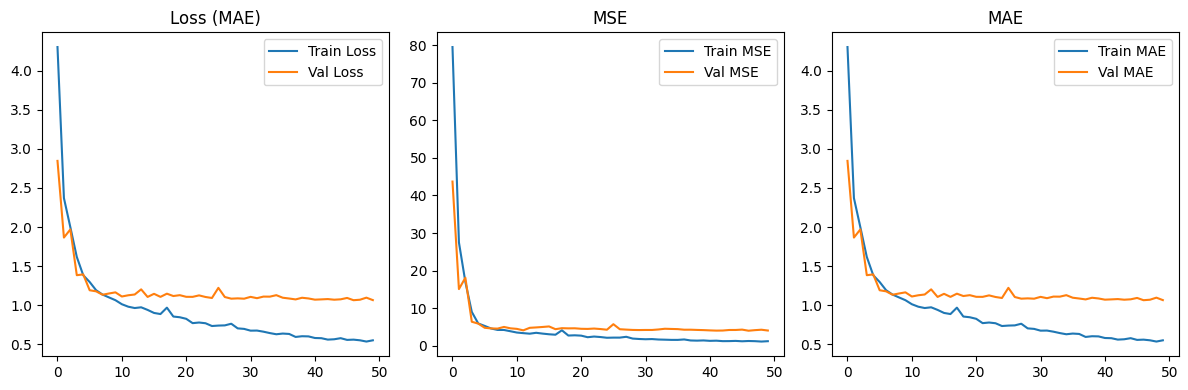

In [10]:
# Plot loss and metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (MAE)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.title('MSE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Predict and evaluate
y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qwk = cohen_kappa_score(y_test.round(), np.round(y_pred), weights='quadratic')

print("\n===== Evaluation Metrics =====")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"QWK Score: {qwk:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step

===== Evaluation Metrics =====
MSE: 10.2966
MAE: 2.4739
R2 Score: 0.8678
QWK Score: 0.9329


In [12]:
# Create a DataFrame of Actual vs Predicted
df_pred = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df_pred.to_csv("baseline_predictions.csv", index=False)
df_pred.head(10)

,Actual,Predicted
0,1.0,5.217735
1,2.0,-0.227193
2,10.0,9.864677
3,1.0,3.785010
4,1.0,4.142924
5,2.0,2.336781
6,3.0,4.873531
7,4.0,3.677469
8,3.0,5.224229
9,3.0,3.873164


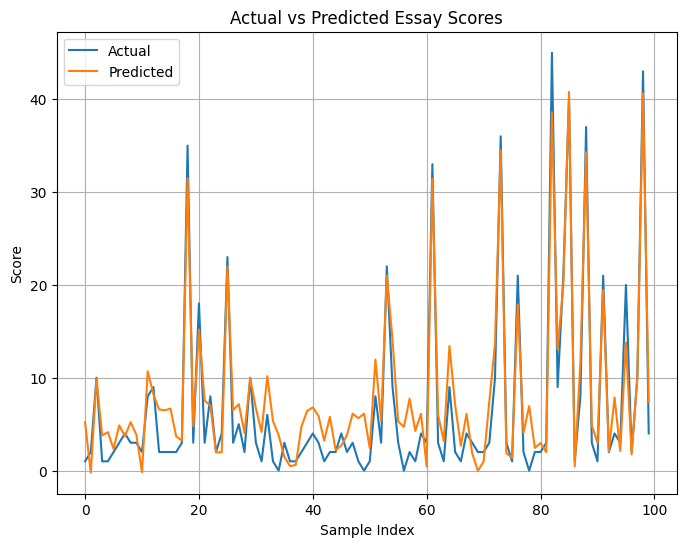

In [13]:
# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.plot(y_test[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title('Actual vs Predicted Essay Scores')
plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()